In [52]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [53]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from copy import copy
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### get some gene annotation the way we used it in the stackups (one from RefSeq, from HiGlass ...)

In [55]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

#### Get expression data measured in TPMs

In [56]:
# #RSEM for siRNA (and 44 and 442)
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/RNAseq/data/siRNA/report2546/rsem/mergedRSEM/merged_TPM_genes.tsv ./merged_TPM_genes_si.tsv
# #RSEM for clones (and 44 and 442)
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/RNAseq/data/siRNA/report2547/rsem/mergedRSEM/merged_TPM_genes.tsv ./merged_TPM_genes_mut.tsv

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [57]:
# column names for the RNA-seq samples generated for various controls, mutants and siRNAs ...
rsem_si_cols = ['rsem.out.S442_IAA',
                'rsem.out.S442_IAAR2',
                'rsem.out.S442_NT',
                'rsem.out.S442_NTR2',
                'rsem.out.S442_siCTRL_IAAR2',
                'rsem.out.S442_siCTRL_NTR2',
                'rsem.out.S442_siCtrl_IAA',
                'rsem.out.S442_siCtrl_NT',
                'rsem.out.S442_siDDX55_IAA',
                'rsem.out.S442_siDDX55_IAAR2',
                'rsem.out.S442_siDDX55_NT',
                'rsem.out.S442_siDDX55_NTR2',
                'rsem.out.S442_siTAF5L_IAA',
                'rsem.out.S442_siTAF5L_IAAR2',
                'rsem.out.S442_siTAF5L_NT',
                'rsem.out.S442_siTAF5L_NTR2',
                'rsem.out.S44_IAA',
                'rsem.out.S44_IAAR2',
                'rsem.out.S44_NT',
                'rsem.out.S44_NTR2']
rsem_mut_cols = ['rsem.out.AAVS1_sg24_IAA',
                'rsem.out.AAVS1_sg24_IAAR2',
                'rsem.out.AAVS1_sg24_NT',
                'rsem.out.AAVS1_sg24_NTR2',
                'rsem.out.DDX55_sg27_IAA',
                'rsem.out.DDX55_sg27_IAAR2',
                'rsem.out.DDX55_sg27_NT',
                'rsem.out.DDX55_sg27_NTR2',
                'rsem.out.DDX55_sg2B_IAA',
                'rsem.out.DDX55_sg2B_IAAR2',
                'rsem.out.DDX55_sg2B_NT',
                'rsem.out.DDX55_sg2B_NTR2',
                'rsem.out.TAF5L_sg23_IAA',
                'rsem.out.TAF5L_sg23_IAAR2',
                'rsem.out.TAF5L_sg23_NT',
                'rsem.out.TAF5L_sg23_NTR2',
                'rsem.out.TAF5L_sg27_IAA',
                'rsem.out.TAF5L_sg27_IAAR2',
                'rsem.out.TAF5L_sg27_NT',
                'rsem.out.TAF5L_sg27_NTR2']

In [58]:
rsem_si_df = pd.read_csv("merged_TPM_genes_si.tsv",sep="\t")[["Id"] + rsem_si_cols]
rsem_mut_df = pd.read_csv("merged_TPM_genes_mut.tsv",sep="\t")[["Id"] + rsem_mut_cols]

# merge si and mut parts to create a monster RNA-seq data set ...
rsem_df = pd.merge(rsem_si_df,rsem_mut_df,how="inner",on="Id")

# some checks
assert np.asarray([(c in rsem_df.columns) for c in rsem_mut_cols]).all()
assert np.asarray([(c in rsem_df.columns) for c in rsem_si_cols]).all()
assert len(rsem_df) == len(rsem_si_df) == len(rsem_mut_df)


#### We'll be using minimum and maximum levels of RNA-seq per gene across samples to define our lists of "commonly" active and inactive genes - so let's calculate min/max and drop all other columns ...

Text(0, 0.5, 'min-TPM')

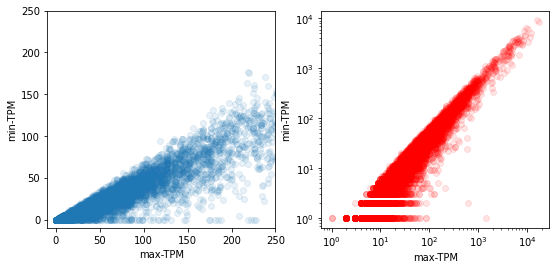

In [59]:
# explore a bit how min vs max behave ...
# are there a lot of genes that go from expressed to not expressed etc ...
_max_col = rsem_df[ rsem_si_cols+rsem_mut_cols ].max(axis=1)
_min_col = rsem_df[ rsem_si_cols+rsem_mut_cols ].min(axis=1)

x = _max_col
y = _min_col

f,axs = plt.subplots(1,2,figsize=(9,4))
ax = axs[0]
ax.scatter(x,y,alpha=0.1)
ax.set_xlabel("max-TPM")
ax.set_ylabel("min-TPM")
ax.set_xlim((-10,250))
ax.set_ylim((-10,250))
ax = axs[1]
ax.loglog(x,y,"ro",alpha=0.1)
ax.set_xlabel("max-TPM")
ax.set_ylabel("min-TPM")

In [60]:
rsem_df = rsem_df[["Id"]]
rsem_df["exp_min"] = _min_col
rsem_df["exp_max"] = _max_col

#### Overlap that refined dataframe of RNA-seq results with "our" list of genes ...

In [61]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

,Id,exp_min,exp_max,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4273,7092,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,12,21,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [62]:
# refine the dataframe  ...
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "exp_min", "exp_max"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end"}

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [63]:
# final adjustments ...
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp_min,exp_max,size
0,chr1,11873,14409,+,0,0,2536
1,chr1,14361,29370,-,28,56,15009
2,chr1,69090,70008,+,0,0,918


In [64]:
all_genes = copy(gdf)

## Deal with gene-CTCF relationships ...
### Deal with CTCF either in the body of the gene or @TSS/TTS ...

In [65]:
# this one excludes genes that have ANY CTCF in the gene-body ...
ctcf_df = bioframe.read_table(
        "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",
#         "CTCF_narrowPeak_HCT116_ENCODE.bed",
        schema="bed3",
        index_col=False
)

ctcf_radius = 2_000
_gene_body = copy(all_genes)
_gene_body["gstart"] = _gene_body["start"] - ctcf_radius
_gene_body["gend"] = _gene_body["end"] + ctcf_radius

gene_ctcf_overlap = bioframe.overlap(
    _gene_body[["chrom","gstart","gend"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","gstart","gend"],
)

display(gene_ctcf_overlap[gene_ctcf_overlap["index"].isna()])


ctcf_index = gene_ctcf_overlap["index_"][
                    ~pd.isna(gene_ctcf_overlap["index"])
                ]
noctcf_index = gene_ctcf_overlap["index_"][
                    pd.isna(gene_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF in the gene_body+/-2kb
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

# here is the strictest set - no CTCF at TSS AND TTS ...
strict_index = noctcf_index

all_genes_noctcf_atall_atall = all_genes.loc[ strict_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_noctcf_atall_atall)} genes have no CTCF in the gene body +/- 2kb"""
)

,index_,chrom_,gstart_,gend_,index,chrom,start,end
1990,1.0,chr1,12361.0,31370.0,NaN,None,NaN,NaN
1991,2.0,chr1,67090.0,72008.0,NaN,None,NaN,NaN
1992,3.0,chr1,132772.0,142566.0,NaN,None,NaN,NaN
1993,4.0,chr1,560759.0,566389.0,NaN,None,NaN,NaN
1994,6.0,chr1,750750.0,757214.0,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...
30232,22287.0,chr9,140507783.0,140515347.0,NaN,None,NaN,NaN
30233,22289.0,chr9,140730870.0,140734968.0,NaN,None,NaN,NaN
30234,22290.0,chr9,140760376.0,140789022.0,NaN,None,NaN,NaN
30235,22291.0,chr9,140770233.0,141021069.0,NaN,None,NaN,NaN


11961 genes have no CTCF in the gene body +/- 2kb


In [66]:
ctcf_df = bioframe.read_table(
        "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",
        schema="bed3",
        index_col=False
)

ctcf_radius = 2_000
_tss = copy(all_genes)
_tss["tss"] = _tss.apply(lambda r: r["start"] if r["strand"]=="+" else r["end"],axis=1)
_tss["tss_mflank"] = _tss["tss"] - ctcf_radius
_tss["tss_pflank"] = _tss["tss"] + ctcf_radius
# _tss[["chrom","tss_mflank","tss_pflank"]]

tss_ctcf_overlap = bioframe.overlap(
    _tss[["chrom","tss_mflank","tss_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tss_mflank","tss_pflank"],
)


_tts = copy(all_genes)
_tts["tts"] = _tts.apply(lambda r: r["end"] if r["strand"]=="+" else r["start"],axis=1)
_tts["tts_mflank"] = _tts["tts"] - ctcf_radius
_tts["tts_pflank"] = _tts["tts"] + ctcf_radius
# _tts[["chrom","tss_mflank","tss_pflank"]]

tts_ctcf_overlap = bioframe.overlap(
    _tts[["chrom","tts_mflank","tts_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tts_mflank","tts_pflank"],
)

#### Now let's actually exclude genes with CTCF near TSS/TTS from downstream analysis ...

In [67]:
ctcf_index = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TSS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

5063 genes have CTCF@TSS,
    17231 genes do not -
    total # of genes 22294


#### same for TTS ...

In [68]:
ctcf_index = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TTS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

2568 genes have CTCF@TTS,
    19726 genes do not -
    total # of genes 22294


#### Combine "exclusion" of CTCF for both TSS and TTS ...

In [69]:
ctcf_index_tts = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index_tts = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TTS
ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
noctcf_index_tts = np.unique(noctcf_index_tts.astype(np.int).values)


ctcf_index_tss = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index_tss = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TSS
ctcf_index_tss = np.unique(ctcf_index_tss.astype(np.int).values)
noctcf_index_tss = np.unique(noctcf_index_tss.astype(np.int).values)

# here is the strictest set - no CTCF at TSS AND TTS ...
strict_index = np.intersect1d(
                        noctcf_index_tts,
                        noctcf_index_tss
                )

all_genes_noctcf_atall = all_genes.loc[ strict_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_noctcf_atall)} genes have no CTCF@TTS and no CTCF@TSS"""
)

15710 genes have no CTCF@TTS and no CTCF@TSS


### Use `gdf` variable to choose which DataFrame with genes we are going to work on  ....

In [70]:
gdf = copy(all_genes_noctcf_atall)

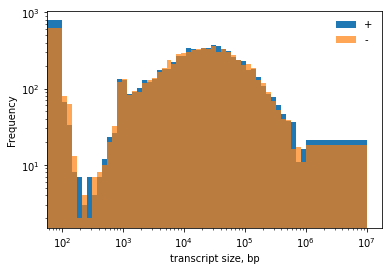

In [72]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

Text(0.5, 1.0, 'max')

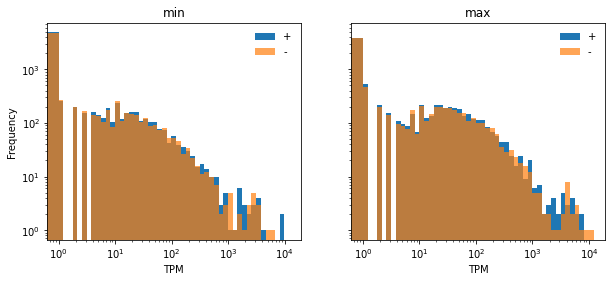

In [73]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
f,axs = plt.subplots(1,2,figsize=(10,4),sharey=True)

ax = axs[0]
gdf[gdf["strand"]=="+"]["exp_min"].plot.hist(bins=bins,log=True,label="+",ax=ax)
gdf[gdf["strand"]=="-"]["exp_min"].plot.hist(bins=bins,log=True,alpha=0.7,label="-",ax=ax)
ax.set_xscale("log")
ax.set_xlabel("TPM")
ax.legend(frameon=False)
ax.set_title("min")
ax = axs[1]
gdf[gdf["strand"]=="+"]["exp_max"].plot.hist(bins=bins,log=True,label="+",ax=ax)
gdf[gdf["strand"]=="-"]["exp_max"].plot.hist(bins=bins,log=True,alpha=0.7,label="-",ax=ax)
ax.set_xscale("log")
ax.set_xlabel("TPM")
ax.legend(frameon=False)
ax.set_title("max")

In [74]:
exp_bin_edges = [0,.5,5,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp_min"] = pd.cut(
    gdf["exp_min"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gexp_max"] = pd.cut(
    gdf["exp_max"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head(2))
display( gdf.groupby(["gexp_min","gsize"]).size().unstack(fill_value=0) )
# finding the common active genes and common inactive ones ...
display( gdf.groupby(["gexp_min","gexp_max","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp_min,exp_max,size,gexp_min,gexp_max,gsize
0,chr1,14361,29370,-,28,56,15009,high,high,short
1,chr1,69090,70008,+,0,0,918,no,no,short


gsize,short,long
gexp_min,,
no,7766,1915
low,1065,747
high,2875,1342


gsize              short  long
gexp_min gexp_max             
no       no         6319  1360
         low        1261   489
         high        186    66
low      no            0     0
         low         187   146
         high        878   601
high     no            0     0
         low           0     0
         high       2875  1342

In [75]:
gdf

,chrom,start,end,strand,exp_min,exp_max,size,gexp_min,gexp_max,gsize
0,chr1,14361,29370,-,28,56,15009,high,high,short
1,chr1,69090,70008,+,0,0,918,no,no,short
2,chr1,134772,140566,-,0,0,5794,no,no,short
3,chr1,562759,564389,-,0,0,1630,no,no,short
4,chr1,752750,755214,+,0,0,2464,no,no,short
...,...,...,...,...,...,...,...,...,...,...
15705,chr9,140513456,140730578,+,15,31,217122,high,high,long
15706,chr9,140732870,140732968,+,0,0,98,no,no,short
15707,chr9,140762376,140787022,-,0,0,24646,no,no,short
15708,chr9,140772233,141019069,+,0,0,246836,no,no,long


In [76]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [77]:
# 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII'
def extract_ins(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )[:: (1 if strand=="+" else -1) ] # flip in place for "-" genes
      for chrom, start, end, strand, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


def extract_ins_noflip(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    no flipping ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )
      for chrom, start, end, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


In [78]:
ctcf_df = bioframe.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",schema="bed3",index_col=False)
# # ctcf_df = pd.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",header=None)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ctcf_df["chrom"].isin(autosomal_chroms)]
ctcf_df = ctcf_df.reset_index(drop=True)
ctcf_df["start"] = ctcf_df["start"] - 200_000
ctcf_df["end"] = ctcf_df["end"] + 200_000
ctcf_df.head(3)

,chrom,start,end
0,chr1,-189849,210508
1,chr1,604937,1005691
2,chr1,675596,1075897


### TSS to TTS scaled profiles ...

In [79]:
# key features/signals that we want to extract for our genes ...
key_features = ['ins_rad21',
            'ins_norad21',
            'ins_mutCtr_CTCF',
            'ins_mutCtr_noCTCF',
            'ins_mutDDX_CTCF',
            'ins_mutDDX_noCTCF',
            'ins_mutTAF_CTCF',
            'ins_mutTAF_noCTCF',
            'ins_siCtr_CTCF',
            'ins_siCtr_noCTCF',
            'ins_siDDX_CTCF',
            'ins_siDDX_noCTCF',
            'ins_siTAF_CTCF',
            'ins_siTAF_noCTCF']

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [80]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp_min","gexp_max","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

extracting ins_rad21 for the genes ...
extracting ins_norad21 for the genes ...
extracting ins_mutCtr_CTCF for the genes ...
extracting ins_mutCtr_noCTCF for the genes ...
extracting ins_mutDDX_CTCF for the genes ...
extracting ins_mutDDX_noCTCF for the genes ...
extracting ins_mutTAF_CTCF for the genes ...
extracting ins_mutTAF_noCTCF for the genes ...
extracting ins_siCtr_CTCF for the genes ...
extracting ins_siCtr_noCTCF for the genes ...
extracting ins_siDDX_CTCF for the genes ...
extracting ins_siDDX_noCTCF for the genes ...
extracting ins_siTAF_CTCF for the genes ...
extracting ins_siTAF_noCTCF for the genes ...


### CTCF insulation/Rloops profiles to match the scaled TSS/TTS profiles ...

#### In this case we are not flipping profiles according to orientation (yet), so we have to use `extract_ins_noflip` function

In [81]:
CTCF_profiles_dict = {}

for feature_name in key_features:
    print(f"extracting {feature_name} for the CTCF peaks ...")
    feature_fname = samples[feature_name]["fname"]
    CTCF_profiles_dict[feature_name] = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

extracting ins_rad21 for the CTCF peaks ...
extracting ins_norad21 for the CTCF peaks ...
extracting ins_mutCtr_CTCF for the CTCF peaks ...
extracting ins_mutCtr_noCTCF for the CTCF peaks ...
extracting ins_mutDDX_CTCF for the CTCF peaks ...
extracting ins_mutDDX_noCTCF for the CTCF peaks ...
extracting ins_mutTAF_CTCF for the CTCF peaks ...
extracting ins_mutTAF_noCTCF for the CTCF peaks ...
extracting ins_siCtr_CTCF for the CTCF peaks ...
extracting ins_siCtr_noCTCF for the CTCF peaks ...
extracting ins_siDDX_CTCF for the CTCF peaks ...
extracting ins_siDDX_noCTCF for the CTCF peaks ...
extracting ins_siTAF_CTCF for the CTCF peaks ...
extracting ins_siTAF_noCTCF for the CTCF peaks ...


### Normalize insulation by subtracting average flanking signal

In [82]:
ins_keys = [k for k in key_features if k.startswith("ins") ]

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for CTCF-peak profiles ...")
    ins_profile = CTCF_profiles_dict[feature_name]
    flank_size = int(len(ins_profile)*0.25)
    # average left and right shoulders of `flank_size` ...
    average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
    # subtract that average flank ...
    CTCF_profiles_dict[feature_name] = CTCF_profiles_dict[feature_name] - average_signal_across_flank
    

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for gene profiles ...")
    for gexp_gsize_key, ins_profile in profiles_dict[feature_name].iteritems():
        flank_size = int(len(ins_profile)*0.25)
        # average left and right shoulders of `flank_size` ...
        average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
        # subtract that average flank ...
        profiles_dict[feature_name][gexp_gsize_key] = ins_profile - average_signal_across_flank


normalizing insulation ins_rad21 for CTCF-peak profiles ...
normalizing insulation ins_norad21 for CTCF-peak profiles ...
normalizing insulation ins_mutCtr_CTCF for CTCF-peak profiles ...
normalizing insulation ins_mutCtr_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_mutDDX_CTCF for CTCF-peak profiles ...
normalizing insulation ins_mutDDX_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_mutTAF_CTCF for CTCF-peak profiles ...
normalizing insulation ins_mutTAF_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_siCtr_CTCF for CTCF-peak profiles ...
normalizing insulation ins_siCtr_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_siDDX_CTCF for CTCF-peak profiles ...
normalizing insulation ins_siDDX_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_siTAF_CTCF for CTCF-peak profiles ...
normalizing insulation ins_siTAF_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_rad21 for gene profiles ...
normalizing insulation in

#### Plotting the profiles ...

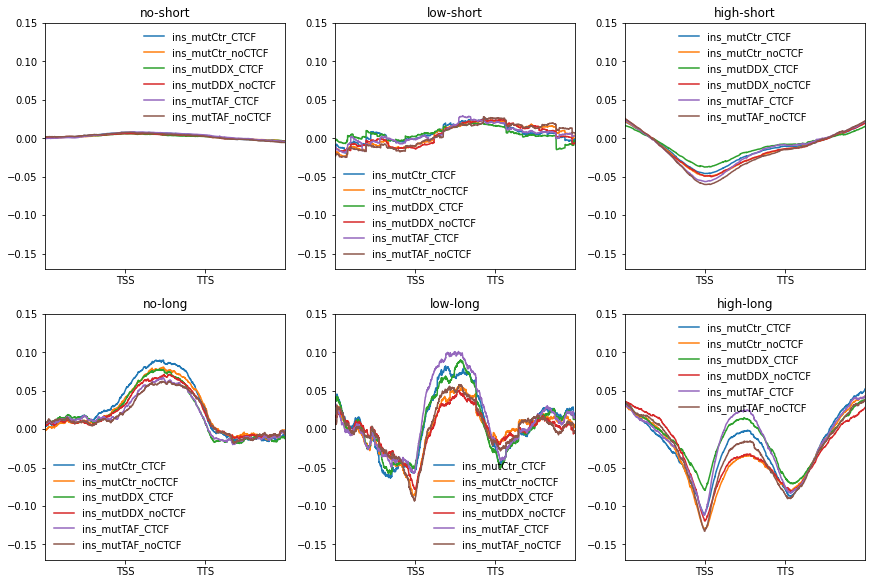

In [83]:
glens=("short","long")
gexps=("no","low","high")

mutant_keys = [k for k in key_features if k.startswith("ins_mut") ]

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in mutant_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.17,.15)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

### Figure 3C itself ! comparing average insulation


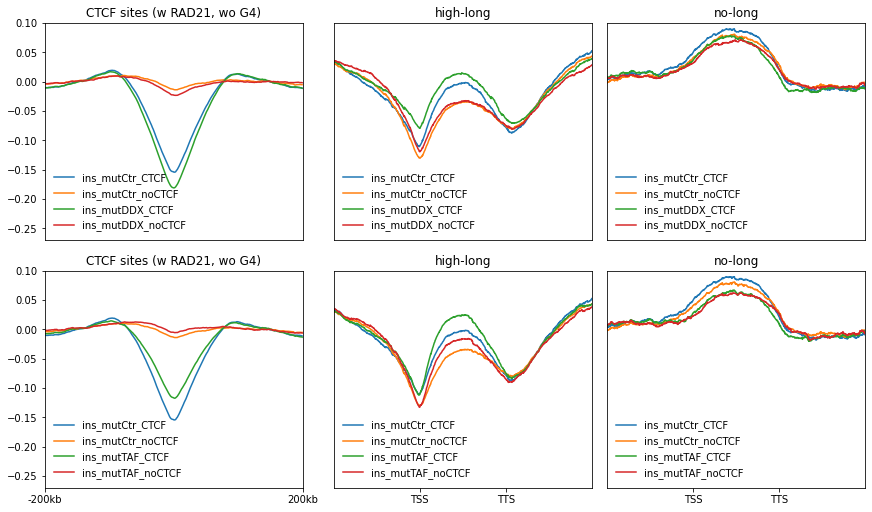

In [84]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutDDX")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

# plt.savefig("Figure6-Mutants-metaGene-insulation.pdf")    

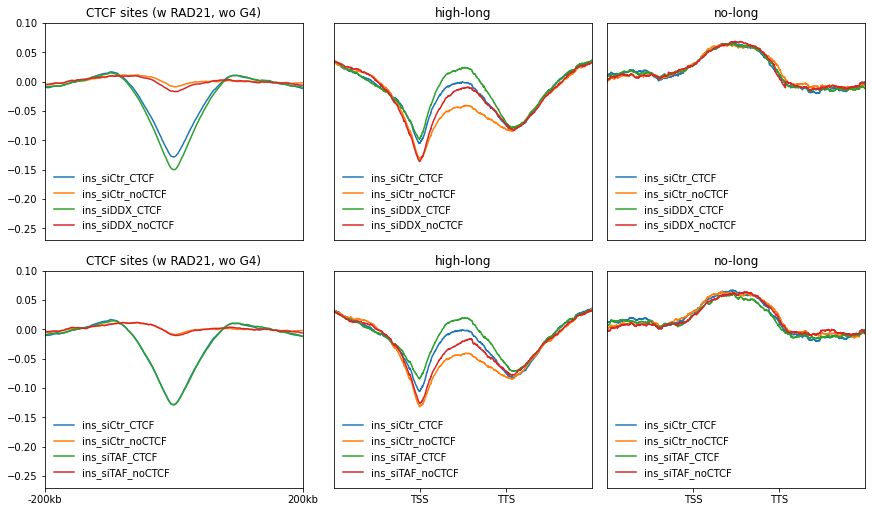

In [85]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siDDX")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

# plt.savefig("Figure6-siRNA-metaGene-insulation.pdf")    

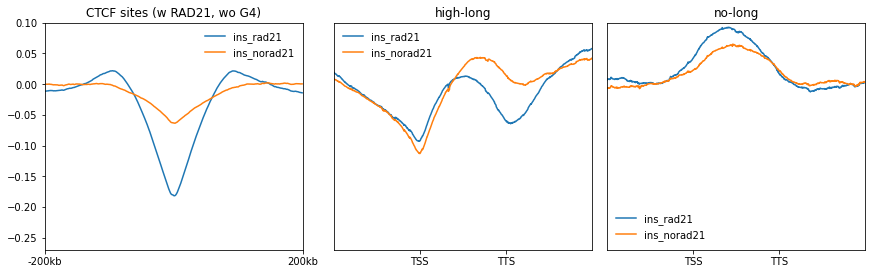

In [86]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)
ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)

ins_keys_figure = ["ins_rad21","ins_norad21"]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

plt.savefig("SuppFig3G-RAD21degron-metaGene-insulation-profile.pdf")

In [87]:
#! scp Figure6*pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# ! scp SuppFig3H-RAD21degron-metaGene-insulation-profile.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

In [88]:
# ! scp SuppFig3G-RAD21degron-metaGene-insulation-profile.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

In [89]:
# ! scp Figure6_unit_with_cpups*.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

In [90]:
## PlaB (splicing inhibition) two replicates pooled together
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/NT-hg19-combined-90000000.mcool ./
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/IAA-hg19-combined-90000000.mcool ./
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/NT-PlaB-hg19-combined-90000000.mcool ./
# ! scp ghpcc:/nl/umw_job_dekker/users/av90w/cooler/20210525_PlaB_same/IAA-PlaB-hg19-combined-90000000.mcool ./


### Try generating Fig 6 - complete layout - i.e. average profiles and some coolpup heatmaps flipped on the side ...
`#!scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP.pickle ./`

In [91]:
from matplotlib import colors
import pickle
import scipy

In [106]:
# load pre-calculated coolpups ...
# !scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP.pickle ./
# !scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups.pickle ./
# !scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups_COMMON_expression.pickle ./
# !scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_200kb_CTCF_Fig6.pickle ./

fp = open("PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups_COMMON_expression.pickle","rb")
cpup_dict = pickle.load(fp)
fp.close()
cpup_samples = list(cpup_dict.keys())

fp = open("PUP_DICT_5kb_200kb_CTCF_Fig6.pickle","rb")
ctcfpup_dict = pickle.load(fp)
fp.close()
ctcfpup_samples = list(ctcfpup_dict.keys())

In [135]:
def get_cpup_hm(sample_name, gexp, gsize, flip45=True ):
    """
    extract cpup pileup from that huge dictionary for a given sample (exp,size)
    and also flip45 if requested ...
    """
    index_cols = ["gexp_min","gexp_max","gsize","orientation"]
    group_name = (gexp, gexp, gsize, '--')
    hm_minus = cpup_dict[sample_name].reset_index().set_index(index_cols).loc[group_name,"data"]
    group_name = (gexp, gexp, gsize, '++')
    hm_plus = cpup_dict[sample_name].reset_index().set_index(index_cols).loc[group_name,"data"]
    # [("med","long","--")]
    hm_average = 0.5*(hm_plus+hm_minus[::-1,::-1])
    if not flip45:
        return hm_average
    else:
        _hm = scipy.ndimage.rotate(hm_average,45,cval=np.nan,reshape=True)
        l,w = _hm.shape
        half_l = l//2
        # removing upper pic spitz vershina "verh == up"
        pic_hide = int(0.33*half_l)
        return _hm[pic_hide:half_l,:]

def get_ctcfpup_hm(sample_name, flip45=True ):
    """
    extract ctcf pile ups ...
    and also flip45 if requested ...
    """
    hm = ctcfpup_dict[sample_name]
    if not flip45:
        return hm
    else:
        _hm = np.nan_to_num(hm, nan =np.nanmean(hm))
        _hm = scipy.ndimage.rotate(_hm,45,cval=np.nan,reshape=True)
        l,w = _hm.shape
        half_l = l//2
        # removing upper pic spitz vershina "verh == up"
        pic_hide = int(0.33*half_l)
        return _hm[pic_hide:half_l,:]


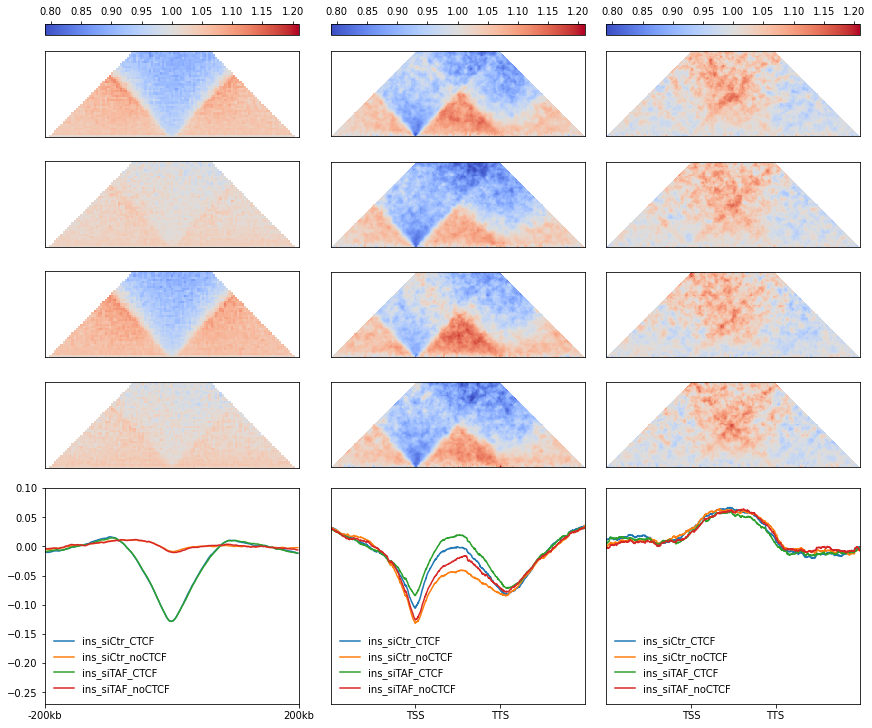

In [152]:
fig = plt.figure(figsize=(12,10),constrained_layout=True)
gs = fig.add_gridspec(1+4+1,3,height_ratios=[0.1,1,1,1,1,2])

# fig6_cpup_samples = ['mutControl-NT.hg19', 'mutControl-IAA.hg19', 'mutDDX55-NT.hg19', 'mutDDX55-IAA.hg19']
# fig6_cpup_samples = ['mutControl-NT.hg19', 'mutControl-IAA.hg19', 'mutTAF5L-NT.hg19', 'mutTAF5L-IAA.hg19']
# fig6_cpup_samples = ['siControl-NT.hg19', 'siControl-IAA.hg19', 'siDDX55-NT.hg19', 'siDDX55-IAA.hg19']
fig6_cpup_samples = ['siControl-NT.hg19', 'siControl-IAA.hg19', 'siTAF5L-NT.hg19', 'siTAF5L-IAA.hg19']

# ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutDDX")) ]
# ins_keys_figure = [k for k in key_features if (k.startswith("ins_mutCtr") or k.startswith("ins_mutTAF")) ]
# ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siDDX")) ]
ins_keys_figure = [k for k in key_features if (k.startswith("ins_siCtr") or k.startswith("ins_siTAF")) ]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[-1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
# ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])


# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[-1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])

    
for j, cpup_sample in enumerate(fig6_cpup_samples):
    #
    # coolpups for expressed genes 
    ax = fig.add_subplot(gs[j+1,1])
    gexp, glen = "high", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cl = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.79, vcenter=1, vmax=1.21))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    # coolpups for non-expressed genes
    ax = fig.add_subplot(gs[j+1,2])
    gexp, glen = "no", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cr = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.79, vcenter=1, vmax=1.21))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    
for j, ctcfpup_sample in enumerate(fig6_cpup_samples):
    # pileups for ctcf
    ax = fig.add_subplot(gs[j+1,0])
    hhh = get_ctcfpup_hm(ctcfpup_sample, flip45=True )
    cctcf = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.79, vcenter=1, vmax=1.21))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
  
# ctcf color bar
ax = fig.add_subplot(gs[0,0])
bar = plt.colorbar(cctcf, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# left color bar
ax = fig.add_subplot(gs[0,1])
bar = plt.colorbar(cl, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# right color bar
ax = fig.add_subplot(gs[0,2])
bar = plt.colorbar(cr, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 


plt.savefig("Figure6_unit_with_cpups_siTAF.pdf")

In [155]:
!scp Figure6_unit_with_cpups_* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Figure6_unit_with_cpups_mutDDX.pdf            100%  705KB 414.3KB/s   00:01    
Figure6_unit_with_cpups_mutTAF.pdf            100%  708KB   3.6MB/s   00:00    
Figure6_unit_with_cpups_siDDX.pdf             100%  729KB   2.4MB/s   00:00    
Figure6_unit_with_cpups_siTAF.pdf             100%  736KB 241.5KB/s   00:03    


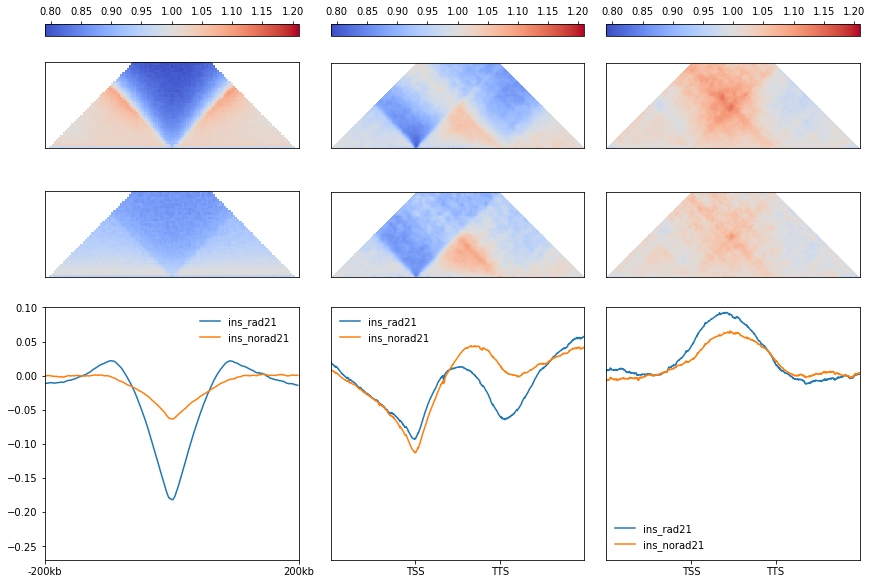

In [156]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(1+2+1,3,height_ratios=[0.1,1,1,2])

fig6_cpup_samples = ['RAD21-NT.hg19', 'RAD21-IAA.hg19']
ins_keys_figure = ["ins_rad21","ins_norad21"]
# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[-1,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
# ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])


# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[-1,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,gexp,glen)],label=feature_name)
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])

    
for j, cpup_sample in enumerate(fig6_cpup_samples):
    #
    # coolpups for expressed genes 
    ax = fig.add_subplot(gs[j+1,1])
    gexp, glen = "high", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cl = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.79, vcenter=1, vmax=1.21))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    # coolpups for non-expressed genes
    ax = fig.add_subplot(gs[j+1,2])
    gexp, glen = "no", "long"
#     if j==0:
#         ax.set_title(f"{gexp}-{glen}")
    hhh = get_cpup_hm(cpup_sample, gexp, glen, flip45=True )
    cr = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.79, vcenter=1, vmax=1.21))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])

    
for j, ctcfpup_sample in enumerate(fig6_cpup_samples):
    # pileups for ctcf
    ax = fig.add_subplot(gs[j+1,0])
    hhh = get_ctcfpup_hm(ctcfpup_sample, flip45=True )
    cctcf = plt.imshow(hhh,interpolation="none",cmap="coolwarm",norm = colors.TwoSlopeNorm(vmin=0.79, vcenter=1, vmax=1.21))
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
  
# ctcf color bar
ax = fig.add_subplot(gs[0,0])
bar = plt.colorbar(cctcf, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# left color bar
ax = fig.add_subplot(gs[0,1])
bar = plt.colorbar(cl, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# right color bar
ax = fig.add_subplot(gs[0,2])
bar = plt.colorbar(cr, cax=ax, orientation="horizontal")
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
